In [1]:
import os
import itertools
import matplotlib as mpl


def set_size(width, fraction=1):
    """Set figure dimensions to avoid scaling in LaTeX.

    From: https://jwalton.info/Embed-Publication-Matplotlib-Latex/

    Parameters
    ----------
    width: float
            Document textwidth or columnwidth in pts
    fraction: float, optional
            Fraction of the width which you wish the figure to occupy

    Returns
    -------
    fig_dim: tuple
            Dimensions of figure in inches
    """
    # Width of figure (in pts)
    fig_width_pt = width * fraction

    # Convert from pt to inches
    inches_per_pt = 1 / 72.27

    # Golden ratio to set aesthetic figure height
    # https://disq.us/p/2940ij3
    golden_ratio = (5**0.5 - 1) / 2

    # Figure width in inches
    fig_width_in = fig_width_pt * inches_per_pt
    # Figure height in inches
    fig_height_in = fig_width_in * golden_ratio

    fig_dim = (fig_width_in, fig_height_in)

    return fig_dim


width, height = set_size(252, fraction=1.0)
widht = 2 * width

# width = 5
# height = width/1.618
fontsize = 9

mpl.rcParams.update(
    {
        "font.size": fontsize,
        "figure.figsize": (width, height),
        "figure.facecolor": "white",
        "savefig.dpi": 360,
        "figure.subplot.bottom": 0.125,
        "figure.edgecolor": "white",
        "xtick.labelsize": fontsize,
        "ytick.labelsize": fontsize,
    }
)

import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

from tqdm.notebook import tqdm

from deephyper.skopt.moo import pareto_front, non_dominated_set, hypervolume
from deephyper.skopt.utils import cook_objective_scaler

In [39]:
# task_name = "navalpropulsion"
# task_name = "parkinsonstelemonitoring"
# task_name = "proteinstructure"
# task_name = "slicelocalization"

tasks = ["navalpropulsion", "parkinsonstelemonitoring", "proteinstructure", "slicelocalization"]
objective_columns = ["objective_0", "objective_1"]
n_objectives = 2
scalers = ["identity", "minmaxlog", "log", "quantile-uniform", "minmax"]
strategies = ["Linear", "Chebyshev", "PBI"]
repetitions = list(range(10))

In [40]:
repetitions

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [74]:
def load_data_from_task(task_name):
    """
        New colums are:
        - strategy: the name of the strategy.
        - scaler: the name of the scaler.
        - task: the name of the task.
    """

    df_results = []

    for scaler, strategy in itertools.product(scalers, strategies):

        for i in repetitions:
            path = f"output/hpobench/{task_name}/{i}/{strategy.lower()}-{scaler}/results.csv"

            if not(os.path.exists(path)):
                print(f"Skipping: {path} because not found.")
                continue

            df = pd.read_csv(path)
            
            if len(df) < 200:
                print(f"Skipping: {path} because imcomplete.")
                continue

            df["repetition"] = i
            df["strategy"] = strategy
            df["scaler"] = scaler
            df_results.append(df)

    other_results = ["random", "nsgaii"]
    for label in other_results:

        for i in repetitions:
            path = f"output/hpobench/{task_name}/{i}/{label}/results.csv"

            if not(os.path.exists(path)):
                print(f"Skipping: {path}")
                continue

            df = pd.read_csv(path)

            if len(df) < 200:
                print(f"Skipping: {path} because imcomplete.")
                continue
            
            df["repetition"] = i
            df["strategy"] = label
            df["scaler"] = "identity"
            df_results.append(df)

    df = pd.concat(df_results, ignore_index=True)
    df.drop(columns=["Unnamed: 0"], inplace=True)
    df["task"] = task_name

    return df


df = pd.concat(
    [load_data_from_task(task_name) for task_name in tasks], ignore_index=True
)

Skipping: output/hpobench/proteinstructure/3/linear-identity/results.csv because not found.
Skipping: output/hpobench/proteinstructure/4/linear-identity/results.csv because not found.
Skipping: output/hpobench/proteinstructure/5/linear-identity/results.csv because not found.
Skipping: output/hpobench/proteinstructure/6/linear-identity/results.csv because not found.
Skipping: output/hpobench/proteinstructure/7/linear-identity/results.csv because not found.
Skipping: output/hpobench/proteinstructure/8/linear-identity/results.csv because not found.
Skipping: output/hpobench/proteinstructure/9/linear-identity/results.csv because not found.
Skipping: output/hpobench/proteinstructure/3/chebyshev-identity/results.csv because not found.
Skipping: output/hpobench/proteinstructure/4/chebyshev-identity/results.csv because not found.
Skipping: output/hpobench/proteinstructure/5/chebyshev-identity/results.csv because not found.
Skipping: output/hpobench/proteinstructure/6/chebyshev-identity/results

In [75]:
df

,p:activation_fn_1,p:activation_fn_2,p:batch_size,p:dropout_1,p:dropout_2,p:init_lr,p:lr_schedule,p:n_units_1,p:n_units_2,objective_0,...,m:timestamp_start,m:timestamp_end,m:budget,m:stopped,m:objective_test,m:objective_val,repetition,strategy,scaler,task
0,relu,tanh,64,0.6,0.3,0.0500,const,128,64,-1.151029,...,1.689166e+09,1.689166e+09,100,False,-1.125535,-1.151029,0,Linear,identity,navalpropulsion
1,tanh,tanh,32,0.0,0.0,0.0005,const,32,32,-0.001227,...,1.689166e+09,1.689166e+09,100,False,-0.001199,-0.001227,0,Linear,identity,navalpropulsion
2,relu,relu,32,0.6,0.0,0.1000,const,128,128,-1.021887,...,1.689166e+09,1.689166e+09,100,False,-1.015133,-1.021887,0,Linear,identity,navalpropulsion
3,relu,relu,8,0.3,0.3,0.0005,const,16,128,-0.152617,...,1.689166e+09,1.689166e+09,100,False,-0.151495,-0.152617,0,Linear,identity,navalpropulsion
4,relu,relu,32,0.6,0.3,0.0005,const,32,128,-0.219029,...,1.689166e+09,1.689166e+09,100,False,-0.217331,-0.219029,0,Linear,identity,navalpropulsion
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80595,relu,relu,16,0.0,0.0,0.0050,cosine,64,256,-0.000872,...,1.689169e+09,1.689169e+09,100,False,-0.001077,-0.000872,0,nsgaii,identity,slicelocalization
80596,relu,relu,64,0.0,0.0,0.0050,cosine,256,32,-0.000411,...,1.689169e+09,1.689169e+09,100,False,-0.000381,-0.000411,0,nsgaii,identity,slicelocalization
80597,relu,tanh,32,0.3,0.3,0.0050,cosine,64,64,-0.005983,...,1.689169e+09,1.689169e+09,100,False,-0.005779,-0.005983,0,nsgaii,identity,slicelocalization
80598,relu,relu,32,0.0,0.6,0.0005,cosine,256,64,-0.004158,...,1.689169e+09,1.689169e+09,100,False,-0.004052,-0.004158,0,nsgaii,identity,slicelocalization


In [76]:
# Scale objectives to be uniformly distributed in [0, 1]

# scaler = cook_objective_scaler("quantile-uniform", None)
scaler = cook_objective_scaler("quantile-uniform", None)
for (task_name,), group_df in df.groupby(["task"]):
    df.loc[group_df.index, objective_columns] = scaler.fit_transform(-group_df[objective_columns].values)

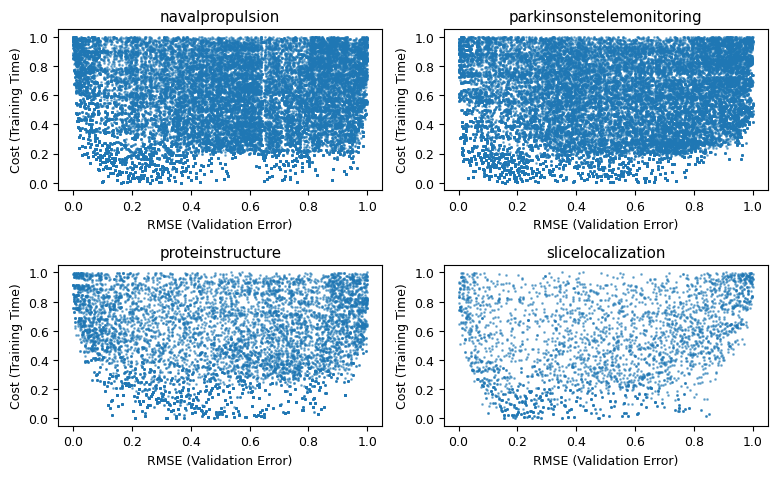

In [77]:
plt.figure(figsize=(width*2.25, height*2.25))

for (task_name,), group_df in df.groupby(["task"]):
    ax = plt.subplot(2, 2, tasks.index(task_name) + 1)
    ax.set_title(task_name)
    plt.scatter(group_df["objective_0"], group_df["objective_1"], s=1, alpha=0.5) 
    plt.xlabel("RMSE (Validation Error)")
    plt.ylabel("Cost (Training Time)")


plt.tight_layout()
plt.show()

In [78]:
def hypervolume_curve(y, ref_point):
    assert np.shape(y)[1] == np.shape(ref_point)[0]

    hv = []
    for i in range(len(y)):
        pf = pareto_front(y[: i + 1])
        hv.append(hypervolume(pf, ref=ref_point))
    return hv

In [79]:
# Compute the hypervolume curve
df["hypervolume"] = None
for group_values, group_df in tqdm(df.groupby(["task", "strategy", "scaler", "repetition"])):
    hv = hypervolume_curve(group_df[objective_columns].values, ref_point=[1.0 for _ in range(n_objectives)])
    df.loc[group_df.index, "hypervolume"] = hv

  0%|          | 0/403 [00:00<?, ?it/s]

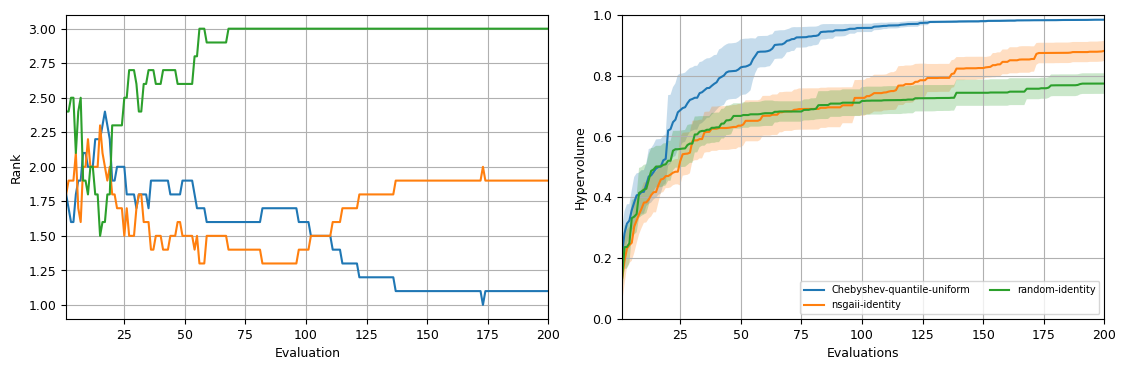

In [96]:
scaler = "quantile-uniform"
# scaler = "minmaxlog"
# scaler = "identity"
# scaler = "log"
# scaler = "minmax"

# filter = ((df["task"] == "navalpropulsion") & (df["scaler"] == scaler)) | (df["strategy"].isin(["random", "nsgaii"]))
# filter = df["task"] == "navalpropulsion"
# filter = (df["task"] == "navalpropulsion") & (
filter = (df["task"] == "parkinsonstelemonitoring") & (
    # (df["scaler"] == scaler) | (df["strategy"].isin(["random", "nsgaii"]))
    # (df["scaler"].isin(["identity", "minmaxlog", "quantile-uniform"])) | (df["strategy"].isin(["random", "nsgaii"]))
    ((df["strategy"] == "Chebyshev") & (df["scaler"].isin(["quantile-uniform"]))) | (df["strategy"].isin(["random", "nsgaii"]))
    # (df["scaler"].isin(["minmax", "quantile-uniform"])) | (df["strategy"].isin(["random", "nsgaii"]))
)

task_rankings = []
task_scores = []
for labels, group_df in df[filter].groupby(["repetition"]):
    group_labels = []
    group_hv = []
    for gv, gdf in group_df.groupby(["strategy", "scaler"]):
        group_labels.append("-".join(gv))
        group_hv.append(gdf["hypervolume"].values)

    group_hv = np.array(group_hv)
    ranks = group_hv.shape[0] - np.argsort(group_hv, axis=0)

    task_scores.append(group_hv)
    task_rankings.append(ranks)

task_rankings = np.array(task_rankings).astype(float)
task_scores = np.array(task_scores).astype(float)

conf = 1.96
n = task_rankings.shape[0]

average_rankings = np.mean(task_rankings, axis=0)
stde_rankings = conf * np.std(task_rankings, axis=0) / np.sqrt(n)

average_scores = np.mean(task_scores, axis=0)
stde_scores = conf * np.std(task_scores, axis=0) / np.sqrt(n)

plt.figure(figsize=(width * 3.25, height*1.75))
plt.subplot(1, 2, 1)
for i, label in enumerate(group_labels): 
    x = np.arange(len(average_rankings[i])) + 1
    plt.plot(x, average_rankings[i], label=label)
    # plt.fill_between(
    #     x,
    #     average_rankings[i] - stde_rankings[i],
    #     average_rankings[i] + stde_rankings[i],
    #     alpha=0.25,
    # )
plt.xlabel("Evaluation")
plt.ylabel("Rank")
plt.grid()
plt.xlim(1, average_rankings.shape[1])

plt.subplot(1, 2, 2)
for i, label in enumerate(group_labels):
    x = np.arange(len(average_scores[i])) + 1
    plt.plot(x, average_scores[i], label=label)
    plt.fill_between(
        x,
        average_scores[i] - stde_scores[i],
        average_scores[i] + stde_scores[i],
        alpha=0.25,
    )
plt.ylim(0, 1)
plt.xlabel("Evaluations")
plt.ylabel("Hypervolume")
plt.legend(ncols=2, loc="lower right", fontsize=7)
plt.grid()
plt.xlim(1, average_rankings.shape[1])

plt.tight_layout()
plt.show()

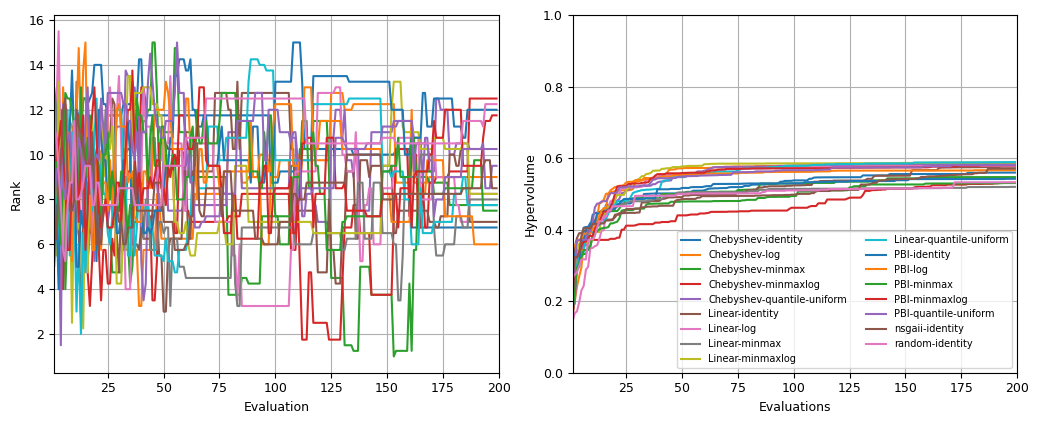

In [63]:
# scaler = "quantile-uniform"
# scaler = "minmaxlog"
# scaler = "identity"
# scaler = "log"
# scaler = "minmax"

task_rankings = []
task_scores = []
for group_values, group_df in df.groupby(["task"]):
    group_labels = []
    group_hv = []
    for gv, gdf in group_df.groupby(["strategy", "scaler"]):
        group_labels.append("-".join(gv))
        group_hv.append(gdf["hypervolume"].values)
    group_hv = np.array(group_hv)
    ranks = group_hv.shape[0] - np.argsort(group_hv, axis=0) - 1

    task_scores.append(group_hv)
    task_rankings.append(ranks)

average_rankings = np.average(task_rankings, axis=0)
average_scores = np.average(task_scores, axis=0)    

plt.figure(figsize=(width*3, height*2))
plt.subplot(1, 2, 1)
for label, ranking in zip(group_labels, average_rankings):
    plt.plot(ranking+1, label=label)
plt.xlabel("Evaluation")
plt.ylabel("Rank")
plt.grid()
plt.xlim(1, average_rankings.shape[1])

plt.subplot(1, 2, 2)
for label, scores in zip(group_labels, average_scores):
    plt.plot(scores, label=label)
plt.ylim(0, 1)
plt.xlabel("Evaluations")
plt.ylabel("Hypervolume")
plt.legend(ncols=2, loc="lower right", fontsize=7)
plt.grid()
plt.xlim(1, average_rankings.shape[1])

plt.tight_layout()
plt.show()

## Comparing Objective Preprocessing

In [ ]:
# For a given preprocessing strategy (e.g., Linear)

strategy = "Linear"

def plot_rank_vs_evaluation_for_objective_scalers(df, strategy):
    ...

## Comparing Scalarization

## Plots

In [8]:
# Impact of scalers
exp_name = "comparing-scalers"
scalers = ["identity", "minmaxlog", "log", "quantile-uniform", "minmax"]
results_path = {
    scaler_name: f"output/hpobench/{task_name}/linear-{scaler_name}"
    for scaler_name in scalers
}

# Impact of strategy
# exp_name = "comparing-strategies"
# scaler_name = "quantile-uniform"
# strategies = ["Linear", "Chebyshev", "PBI"]
# results_path = {
#     strategy_name: f"output/hpobench/{task_name}/{strategy_name.lower()}-{scaler_name}"
#     for strategy_name in strategies
# }

results_path["random"] = f"output/hpobench/{task_name}/random"

In [9]:
results = {
    k: pd.read_csv(os.path.join(v, "results.csv")) for k, v in results_path.items()
}


def get_fitted_scaler_from_data(results, n_objectives, scaler_name="quantile-uniform"):
    objective_columns = [f"objective_{i}" for i in range(n_objectives)]
    objectives_concat = []
    for k, df in results.items():
        df[objective_columns] = -df[objective_columns]
        objectives_concat.append(df[objective_columns].values)
    objectives_concat = np.concatenate(objectives_concat, axis=0)

    scaler = cook_objective_scaler(scaler_name, None)
    scaler.fit(objectives_concat)
    return scaler


scaler = get_fitted_scaler_from_data(
    results, n_objectives=2, scaler_name="quantile-uniform"
)

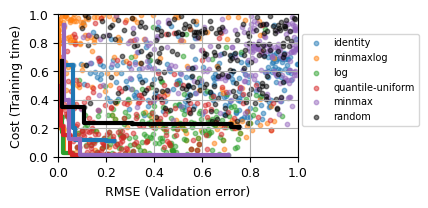

In [10]:
plt.figure(figsize=(width + width / 4, height))

for k, df in results.items():
    objectives = df[objective_columns].values
    objectives = scaler.transform(objectives)
    plt.scatter(
        objectives[:, 0],
        objectives[:, 1],
        label=k,
        s=10,
        alpha=0.5,
        c="black" if "random" in k else None,
    )

    pf = pareto_front(objectives, sort=True)

    plt.step(
        pf[:, 0],
        pf[:, 1],
        where="pre",
        c="black" if "random" in k else None,
        linewidth=3.0
        )

plt.xlabel("RMSE (Validation error)")
plt.ylabel("Cost (Training time)")
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.legend(bbox_to_anchor=(1.0, 0.9), fontsize=7)
plt.grid()
plt.tight_layout()
plt.savefig(f"output/hpobench/{task_name}/scatter-{exp_name}.png")
plt.show()

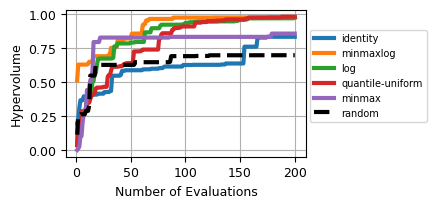

In [11]:
ref_point = np.array([1.0, 1.0])

plt.figure(figsize=(width+width/4, height))

for k, df in results.items():
    objectives = df[objective_columns].values
    objectives = scaler.transform(objectives)

    hv = []
    for i in range(len(df)):
        pf = pareto_front(objectives[: i + 1])
        hv.append(hypervolume(pf, ref=ref_point))

    if "random" in k:
        plot_kwargs = {"color": "black", "linewidth": 2, "linestyle": "--"}
    else:
        plot_kwargs = {}
    plot_kwargs["linewidth"] = 3.0
    
    plt.plot(np.arange(len(hv)) + 1, hv, label=k, **plot_kwargs)

plt.xlabel("Number of Evaluations")
plt.ylabel("Hypervolume")

plt.legend(bbox_to_anchor = (1.0, 0.9), fontsize=7)
plt.grid()
plt.tight_layout()
plt.savefig(f"output/hpobench/{task_name}/hv-comparing-{exp_name}.png")
plt.show()